# 聚类算法实现与验证：K-means与FCM

本notebook实现基于百度飞桨的K-means和FCM（模糊C均值）聚类算法，并在多个数据集上进行验证。

## 目录
1. 算法原理与流程
2. 无监督聚类评价标准
3. 算法实现
4. 实验验证
   - Sonar数据集
   - MNIST数据集
   - 三张图像的验证
5. 结果分析与总结


## 1. 算法原理与流程

### 1.1 K-means算法

**算法原理：**
K-means是一种硬聚类算法，每个样本只能属于一个类别。算法通过迭代优化，最小化所有点到其所属簇中心的距离平方和。

**目标函数：**
$$J = \sum_{i=1}^{k}\sum_{x \in C_i}||x - \mu_i||^2$$

**算法流程：**
1. 随机初始化k个聚类中心
2. 将每个样本分配到最近的聚类中心
3. 重新计算每个簇的中心（簇内所有点的均值）
4. 重复步骤2-3，直到收敛（中心不再变化或达到最大迭代次数）

### 1.2 FCM算法（模糊C均值）

**算法原理：**
FCM是一种软聚类算法，允许一个样本以不同的隶属度属于多个类别。

**目标函数：**
$$J_m = \sum_{i=1}^{n}\sum_{j=1}^{c}u_{ij}^m||x_i - c_j||^2$$

其中：
- $u_{ij}$ 是样本$x_i$属于簇$j$的隶属度
- $m$ 是模糊系数（通常取2）
- $c_j$ 是第$j$个聚类中心

**算法流程：**
1. 随机初始化隶属度矩阵U
2. 根据隶属度计算聚类中心：$c_j = \frac{\sum_{i=1}^{n}u_{ij}^m x_i}{\sum_{i=1}^{n}u_{ij}^m}$
3. 更新隶属度矩阵：$u_{ij} = \frac{1}{\sum_{k=1}^{c}(\frac{||x_i - c_j||}{||x_i - c_k||})^{\frac{2}{m-1}}}$
4. 重复步骤2-3，直到收敛


## 2. 无监督聚类评价标准

### 2.1 常见评价指标

1. **轮廓系数（Silhouette Coefficient）**
   - 范围：[-1, 1]，越接近1越好
   - 综合考虑簇内紧密度和簇间分离度
   - 计算公式：$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$

2. **Davies-Bouldin指数（DB Index）**
   - 值越小越好
   - 衡量簇内离散度与簇间距离的比值

3. **Calinski-Harabasz指数（CH Index）**
   - 值越大越好
   - 簇间方差与簇内方差的比值

4. **Dunn指数**
   - 值越大越好
   - 最小簇间距离与最大簇内距离的比值

### 2.2 选择的评价指标

本实验选择 **轮廓系数（Silhouette Coefficient）** 作为主要评价指标，原因如下：
- 易于理解和解释
- 同时考虑簇的紧密度和分离度
- 不需要知道真实标签
- 适用于不同形状和大小的簇

同时，我们也会计算 **Davies-Bouldin指数** 和 **Calinski-Harabasz指数** 作为辅助参考。


## 数据集准备说明

### 在AI Studio中添加数据集

本项目需要使用以下数据集：
1. **Sonar数据集**（需要手动添加）
2. **MNIST数据集**（由PaddlePaddle自动下载）

#### Sonar数据集添加步骤：

1. **下载数据集**：
   - 访问 UCI Machine Learning Repository
   - 链接: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)
   - 下载 `sonar.all-data` 文件

2. **在AI Studio中添加**：
   - 在AI Studio项目中，点击"数据集"选项卡
   - 选择"添加数据集"
   - 上传下载的 `sonar.all-data` 文件
   - 或者使用AI Studio提供的公开数据集（搜索"sonar"）

3. **数据集路径**：
   - AI Studio会将数据集挂载到 `/home/aistudio/data/` 目录
   - 代码会自动尝试从多个可能路径加载

#### MNIST数据集：
- 无需手动下载，PaddlePaddle会自动下载并缓存
- 首次运行时会自动从官方源下载



## 3. 环境准备与算法实现


In [46]:
import paddle
import paddle.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
paddle.seed(1020)
np.random.seed(1020)

# ========== 中文字体设置（解决中文显示问题）==========
import matplotlib
from matplotlib.font_manager import FontProperties

# 尝试多种中文字体（按优先级）
chinese_fonts = [
    'SimHei',           # 黑体 (Windows)
    'Microsoft YaHei'   # 微软雅黑 (Windows)
]

plt.rcParams['font.sans-serif'] = chinese_fonts
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.size'] = 10

# 测试中文显示
try:
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.text(0.5, 0.5, '测试')
    plt.close(fig)
    print("中文字体设置成功")
except Exception as e:
    print(f"中文字体设置可能有问题: {e}")

print(f"\n{'='*60}")
print(f"PaddlePaddle版本: {paddle.__version__}")
print(f"运行设备: {'GPU' if paddle.is_compiled_with_cuda() else 'CPU'}")
print(f"Matplotlib版本: {matplotlib.__version__}")
print(f"{'='*60}")


中文字体设置成功

PaddlePaddle版本: 3.2.0
运行设备: CPU
Matplotlib版本: 3.10.0


### 3.1 K-means算法实现


In [47]:
class KMeans:
    """基于PaddlePaddle实现的K-means聚类算法"""
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, init='random'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
        self.centers = None
        self.labels = None
        
    def fit(self, X):
        """训练K-means模型"""
        if not isinstance(X, paddle.Tensor):
            X = paddle.to_tensor(X, dtype='float32')
        
        # 随机初始化聚类中心
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centers = X[indices]
        
        for iteration in range(self.max_iter):
            # 计算距离并分配标签
            distances = paddle.stack([
                paddle.sum((X - center.unsqueeze(0))**2, axis=1)
                for center in self.centers
            ])
            self.labels = paddle.argmin(distances, axis=0)
            
            # 更新聚类中心
            new_centers = paddle.stack([
                paddle.mean(X[self.labels == k], axis=0) 
                if paddle.sum(self.labels == k) > 0 
                else self.centers[k]
                for k in range(self.n_clusters)
            ])
            
            # 检查收敛
            center_shift = paddle.sum((new_centers - self.centers)**2)
            self.centers = new_centers
            if center_shift < self.tol:
                break
        
        return self
    
    def predict(self, X):
        """预测新样本的类别"""
        if not isinstance(X, paddle.Tensor):
            X = paddle.to_tensor(X, dtype='float32')
        
        distances = paddle.stack([
            paddle.sum((X - center.unsqueeze(0))**2, axis=1)
            for center in self.centers
        ])
        return paddle.argmin(distances, axis=0)
    
    def fit_predict(self, X):
        """训练模型并返回预测结果"""
        self.fit(X)
        return self.labels

print("K-means算法实现完成！")


K-means算法实现完成！


### 3.2 FCM算法实现


In [48]:
class FCM:
    """基于PaddlePaddle实现的FCM（模糊C均值）聚类算法"""
    def __init__(self, n_clusters=3, max_iter=300, m=2, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m  # 模糊系数
        self.tol = tol
        self.centers = None
        self.u = None  # 隶属度矩阵
        self.labels = None
        
    def _init_membership(self, n_samples):
        """初始化隶属度矩阵"""
        u = np.random.rand(n_samples, self.n_clusters)
        u = u / np.sum(u, axis=1, keepdims=True)
        return paddle.to_tensor(u, dtype='float32')
    
    def _update_centers(self, X, u):
        """更新聚类中心"""
        um = paddle.pow(u, self.m)
        centers = paddle.matmul(um.T, X) / paddle.sum(um, axis=0, keepdim=True).T
        return centers
    
    def _update_membership(self, X, centers):
        """更新隶属度矩阵"""
        n_samples = X.shape[0]
        u = paddle.zeros([n_samples, self.n_clusters])
        
        for i in range(n_samples):
            distances = paddle.sqrt(
                paddle.sum((X[i:i+1] - centers)**2, axis=1) + 1e-10
            )
            for j in range(self.n_clusters):
                u[i, j] = 1.0 / paddle.sum(
                    paddle.pow(distances[j] / distances, 2.0 / (self.m - 1))
                )
        return u
    
    def fit(self, X):
        """训练FCM模型"""
        if not isinstance(X, paddle.Tensor):
            X = paddle.to_tensor(X, dtype='float32')
        
        n_samples = X.shape[0]
        self.u = self._init_membership(n_samples)
        
        for iteration in range(self.max_iter):
            # 更新聚类中心
            self.centers = self._update_centers(X, self.u)
            
            # 更新隶属度矩阵
            u_new = self._update_membership(X, self.centers)
            
            # 检查收敛
            u_diff = paddle.sum(paddle.abs(u_new - self.u))
            self.u = u_new
            if u_diff < self.tol:
                break
        
        # 硬分类：选择隶属度最大的类
        self.labels = paddle.argmax(self.u, axis=1)
        return self
    
    def predict(self, X):
        """预测新样本的类别"""
        if not isinstance(X, paddle.Tensor):
            X = paddle.to_tensor(X, dtype='float32')
        u = self._update_membership(X, self.centers)
        return paddle.argmax(u, axis=1)
    
    def fit_predict(self, X):
        """训练模型并返回预测结果"""
        self.fit(X)
        return self.labels

print("FCM算法实现完成！")


FCM算法实现完成！


### 3.3 评价与可视化函数


In [49]:
def evaluate_clustering(X, labels, algorithm_name):
    """评估聚类结果"""
    if isinstance(X, paddle.Tensor):
        X = X.numpy()
    if isinstance(labels, paddle.Tensor):
        labels = labels.numpy()
    
    n_labels = len(np.unique(labels))
    if n_labels == 1:
        print(f"{algorithm_name} - 所有样本被分配到同一个簇")
        return None
    
    # 计算评价指标
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    print(f"\n{'='*60}")
    print(f"{algorithm_name} 聚类评估结果")
    print(f"{'='*60}")
    print(f"轮廓系数 (Silhouette): {silhouette:.4f} (越大越好, 范围[-1,1])")
    print(f"Davies-Bouldin指数: {davies_bouldin:.4f} (越小越好)")
    print(f"Calinski-Harabasz指数: {calinski_harabasz:.2f} (越大越好)")
    print(f"簇数量: {n_labels}")
    
    return {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz
    }

def plot_clustering_results(X, labels_kmeans, labels_fcm, title, true_labels=None):
    """可视化聚类结果"""
    if isinstance(X, paddle.Tensor):
        X = X.numpy()
    if isinstance(labels_kmeans, paddle.Tensor):
        labels_kmeans = labels_kmeans.numpy()
    if isinstance(labels_fcm, paddle.Tensor):
        labels_fcm = labels_fcm.numpy()
    
    # PCA降维到2D
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
    else:
        X_2d = X
    
    # 创建子图
    n_plots = 3 if true_labels is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    if n_plots == 2:
        axes = [axes[0], axes[1]]
    
    # K-means结果
    scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, 
                               cmap='viridis', alpha=0.6, s=50)
    axes[0].set_title(f'K-means聚类\n{title}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('PC1' if X.shape[1] > 2 else 'Feature 1')
    axes[0].set_ylabel('PC2' if X.shape[1] > 2 else 'Feature 2')
    plt.colorbar(scatter1, ax=axes[0])
    
    # FCM结果
    scatter2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_fcm, 
                               cmap='viridis', alpha=0.6, s=50)
    axes[1].set_title(f'FCM聚类\n{title}', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('PC1' if X.shape[1] > 2 else 'Feature 1')
    axes[1].set_ylabel('PC2' if X.shape[1] > 2 else 'Feature 2')
    plt.colorbar(scatter2, ax=axes[1])
    
    # 真实标签
    if true_labels is not None:
        if isinstance(true_labels, paddle.Tensor):
            true_labels = true_labels.numpy()
        scatter3 = axes[2].scatter(X_2d[:, 0], X_2d[:, 1], c=true_labels, 
                                   cmap='viridis', alpha=0.6, s=50)
        axes[2].set_title(f'真实标签\n{title}', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('PC1' if X.shape[1] > 2 else 'Feature 1')
        axes[2].set_ylabel('PC2' if X.shape[1] > 2 else 'Feature 2')
        plt.colorbar(scatter3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

print("评价与可视化函数定义完成！")


评价与可视化函数定义完成！


## 4. 实验验证

### 4.1 Sonar数据集

Sonar数据集包含声纳信号，用于区分金属圆柱(M)和岩石(R)。数据集包含208个样本，每个样本有60个特征。


In [50]:
# 加载Sonar数据集（从AI Studio环境）
print("加载Sonar数据集...")

# 在AI Studio中，数据集通常位于 /home/aistudio/data/ 目录
# 如果你已经在AI Studio中添加了Sonar数据集，请修改下面的路径
import os

# 尝试从AI Studio数据目录加载
data_paths = [
    '/home/aistudio/data/sonar.all-data',  # AI Studio常用路径
    '/home/aistudio/data/sonar/sonar.all-data',
    'data/sonar.all-data',  # 相对路径
    './sonar.all-data'
]

sonar_loaded = False
for data_path in data_paths:
    if os.path.exists(data_path):
        try:
            sonar_df = pd.read_csv(data_path, header=None)
            X_sonar = sonar_df.iloc[:, :-1].values
            y_sonar = sonar_df.iloc[:, -1].values
            print(f"成功从 {data_path} 加载Sonar数据集")
            sonar_loaded = True
            break
        except Exception as e:
            print(f"尝试从 {data_path} 加载失败: {e}")

# 如果本地没有找到数据集，尝试在线下载（仅作备用）
if not sonar_loaded:
    print("本地未找到Sonar数据集，尝试在线下载...")
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
        sonar_df = pd.read_csv(url, header=None)
        X_sonar = sonar_df.iloc[:, :-1].values
        y_sonar = sonar_df.iloc[:, -1].values
        print("在线下载成功")
        sonar_loaded = True
    except Exception as e:
        print(f"在线下载失败: {e}")

# 如果仍然加载失败，生成模拟数据（仅用于测试代码）
if not sonar_loaded:
    print("使用模拟Sonar数据（仅用于测试）...")
    np.random.seed(42)
    X_class1 = np.random.randn(104, 60) + np.array([1]*60)
    X_class2 = np.random.randn(104, 60) - np.array([1]*60)
    X_sonar = np.vstack([X_class1, X_class2])
    y_sonar = np.array(['M']*104 + ['R']*104)

# 数据标准化
scaler = StandardScaler()
X_sonar_scaled = scaler.fit_transform(X_sonar)

print(f"\n数据集信息：")
print(f"  形状: {X_sonar_scaled.shape}")
print(f"  类别: {np.unique(y_sonar)}")
print(f"  样本数: {len(X_sonar_scaled)}")


加载Sonar数据集...
本地未找到Sonar数据集，尝试在线下载...
在线下载成功

数据集信息：
  形状: (208, 60)
  类别: ['M' 'R']
  样本数: 208


In [51]:
# Sonar数据集 - K-means聚类
print("\n" + "="*70)
print("实验1: Sonar数据集 - K-means聚类")
print("="*70)

kmeans_sonar = KMeans(n_clusters=2, max_iter=300)
labels_kmeans_sonar = kmeans_sonar.fit_predict(X_sonar_scaled)
metrics_kmeans_sonar = evaluate_clustering(X_sonar_scaled, labels_kmeans_sonar, "K-means (Sonar)")



实验1: Sonar数据集 - K-means聚类

K-means (Sonar) 聚类评估结果
轮廓系数 (Silhouette): 0.2197 (越大越好, 范围[-1,1])
Davies-Bouldin指数: 2.1544 (越小越好)
Calinski-Harabasz指数: 35.41 (越大越好)
簇数量: 2


In [52]:
# Sonar数据集 - FCM聚类
print("\n" + "="*70)
print("实验2: Sonar数据集 - FCM聚类")
print("="*70)

fcm_sonar = FCM(n_clusters=2, max_iter=300, m=2)
labels_fcm_sonar = fcm_sonar.fit_predict(X_sonar_scaled)
metrics_fcm_sonar = evaluate_clustering(X_sonar_scaled, labels_fcm_sonar, "FCM (Sonar)")



实验2: Sonar数据集 - FCM聚类

FCM (Sonar) 聚类评估结果
轮廓系数 (Silhouette): 0.1285 (越大越好, 范围[-1,1])
Davies-Bouldin指数: 2.4950 (越小越好)
Calinski-Harabasz指数: 30.71 (越大越好)
簇数量: 2


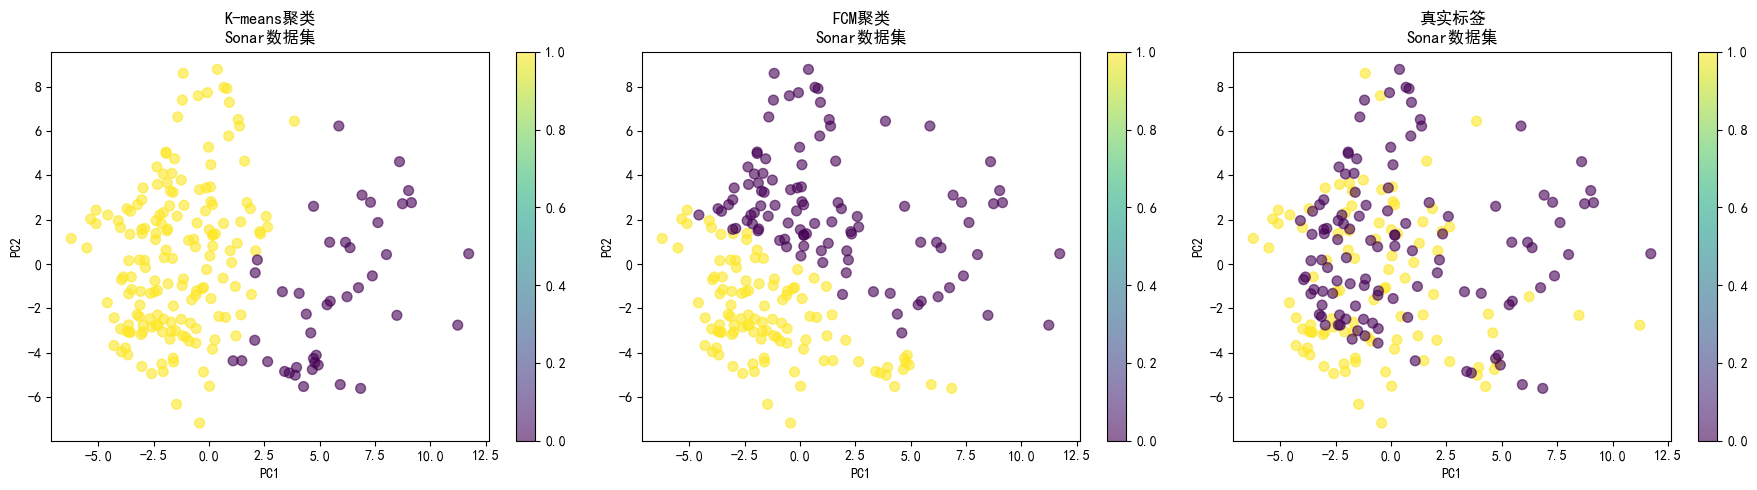

In [12]:
# 可视化Sonar聚类结果
y_sonar_numeric = np.array([0 if label == 'M' else 1 for label in y_sonar])
plot_clustering_results(X_sonar_scaled, labels_kmeans_sonar, labels_fcm_sonar, 
                       "Sonar数据集", true_labels=y_sonar_numeric)


### 4.2 MNIST数据集

MNIST手写数字数据集，包含0-9的手写数字图像。为了提高计算效率，我们使用前5000个样本的子集。


In [53]:
# 加载MNIST数据集（从AI Studio环境或Paddle内置）
print("加载MNIST数据集...")

from paddle.vision.datasets import MNIST

# 使用PaddlePaddle内置MNIST数据集（不使用transform，保持原始数据）
mnist_train = MNIST(mode='train')

# 提取子集（前5000个样本）
subset_size = 5000
X_mnist = []
y_mnist = []

for i in range(min(subset_size, len(mnist_train))):
    img, label = mnist_train[i]
    # img已经是numpy.ndarray，直接flatten即可
    img_array = np.array(img).flatten()
    X_mnist.append(img_array)
    y_mnist.append(label)

X_mnist = np.array(X_mnist)
y_mnist = np.array(y_mnist)

print(f"原始数据形状: {X_mnist.shape}")
print(f"数据范围: [{X_mnist.min()}, {X_mnist.max()}]")

# 数据标准化
scaler_mnist = StandardScaler()
X_mnist_scaled = scaler_mnist.fit_transform(X_mnist)

# PCA降维到50维以加快计算
print("\n使用PCA降维至50维...")
pca_mnist = PCA(n_components=50)
X_mnist_pca = pca_mnist.fit_transform(X_mnist_scaled)

print(f"降维后形状: {X_mnist_pca.shape}")
print(f"保留方差比例: {np.sum(pca_mnist.explained_variance_ratio_):.2%}")


加载MNIST数据集...
原始数据形状: (5000, 784)
数据范围: [0, 255]

使用PCA降维至50维...
降维后形状: (5000, 50)
保留方差比例: 61.42%


In [54]:
# MNIST数据集 - K-means聚类（10类）
print("\n" + "="*70)
print("实验3: MNIST数据集 - K-means聚类")
print("="*70)

kmeans_mnist = KMeans(n_clusters=10, max_iter=100)
labels_kmeans_mnist = kmeans_mnist.fit_predict(X_mnist_pca)
metrics_kmeans_mnist = evaluate_clustering(X_mnist_pca, labels_kmeans_mnist, "K-means (MNIST)")



实验3: MNIST数据集 - K-means聚类

K-means (MNIST) 聚类评估结果
轮廓系数 (Silhouette): 0.0842 (越大越好, 范围[-1,1])
Davies-Bouldin指数: 2.3046 (越小越好)
Calinski-Harabasz指数: 216.02 (越大越好)
簇数量: 10


In [55]:
# MNIST数据集 - FCM聚类（10类）
print("\n" + "="*70)
print("实验4: MNIST数据集 - FCM聚类")
print("="*70)

fcm_mnist = FCM(n_clusters=10, max_iter=100, m=2)
labels_fcm_mnist = fcm_mnist.fit_predict(X_mnist_pca)
metrics_fcm_mnist = evaluate_clustering(X_mnist_pca, labels_fcm_mnist, "FCM (MNIST)")



实验4: MNIST数据集 - FCM聚类

FCM (MNIST) 聚类评估结果
轮廓系数 (Silhouette): -0.1273 (越大越好, 范围[-1,1])
Davies-Bouldin指数: 16.0220 (越小越好)
Calinski-Harabasz指数: 3.18 (越大越好)
簇数量: 7


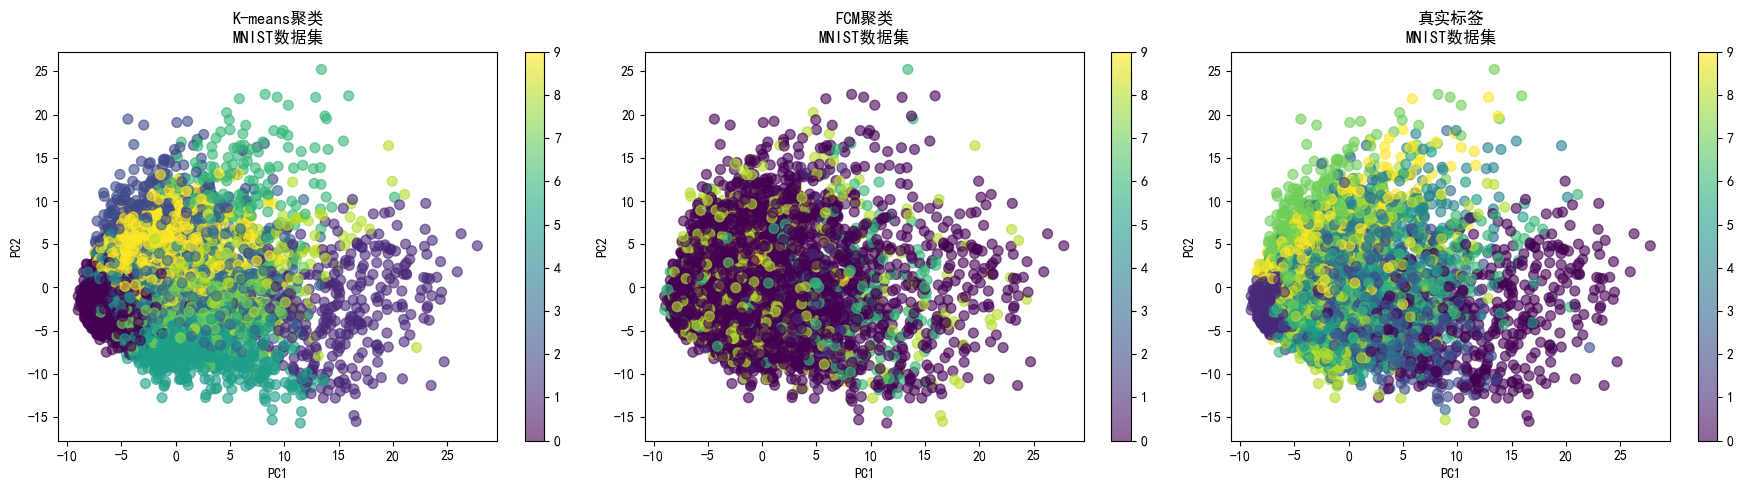

In [56]:
# 可视化MNIST聚类结果
plot_clustering_results(X_mnist_pca, labels_kmeans_mnist, labels_fcm_mnist,
                       "MNIST数据集", true_labels=y_mnist)


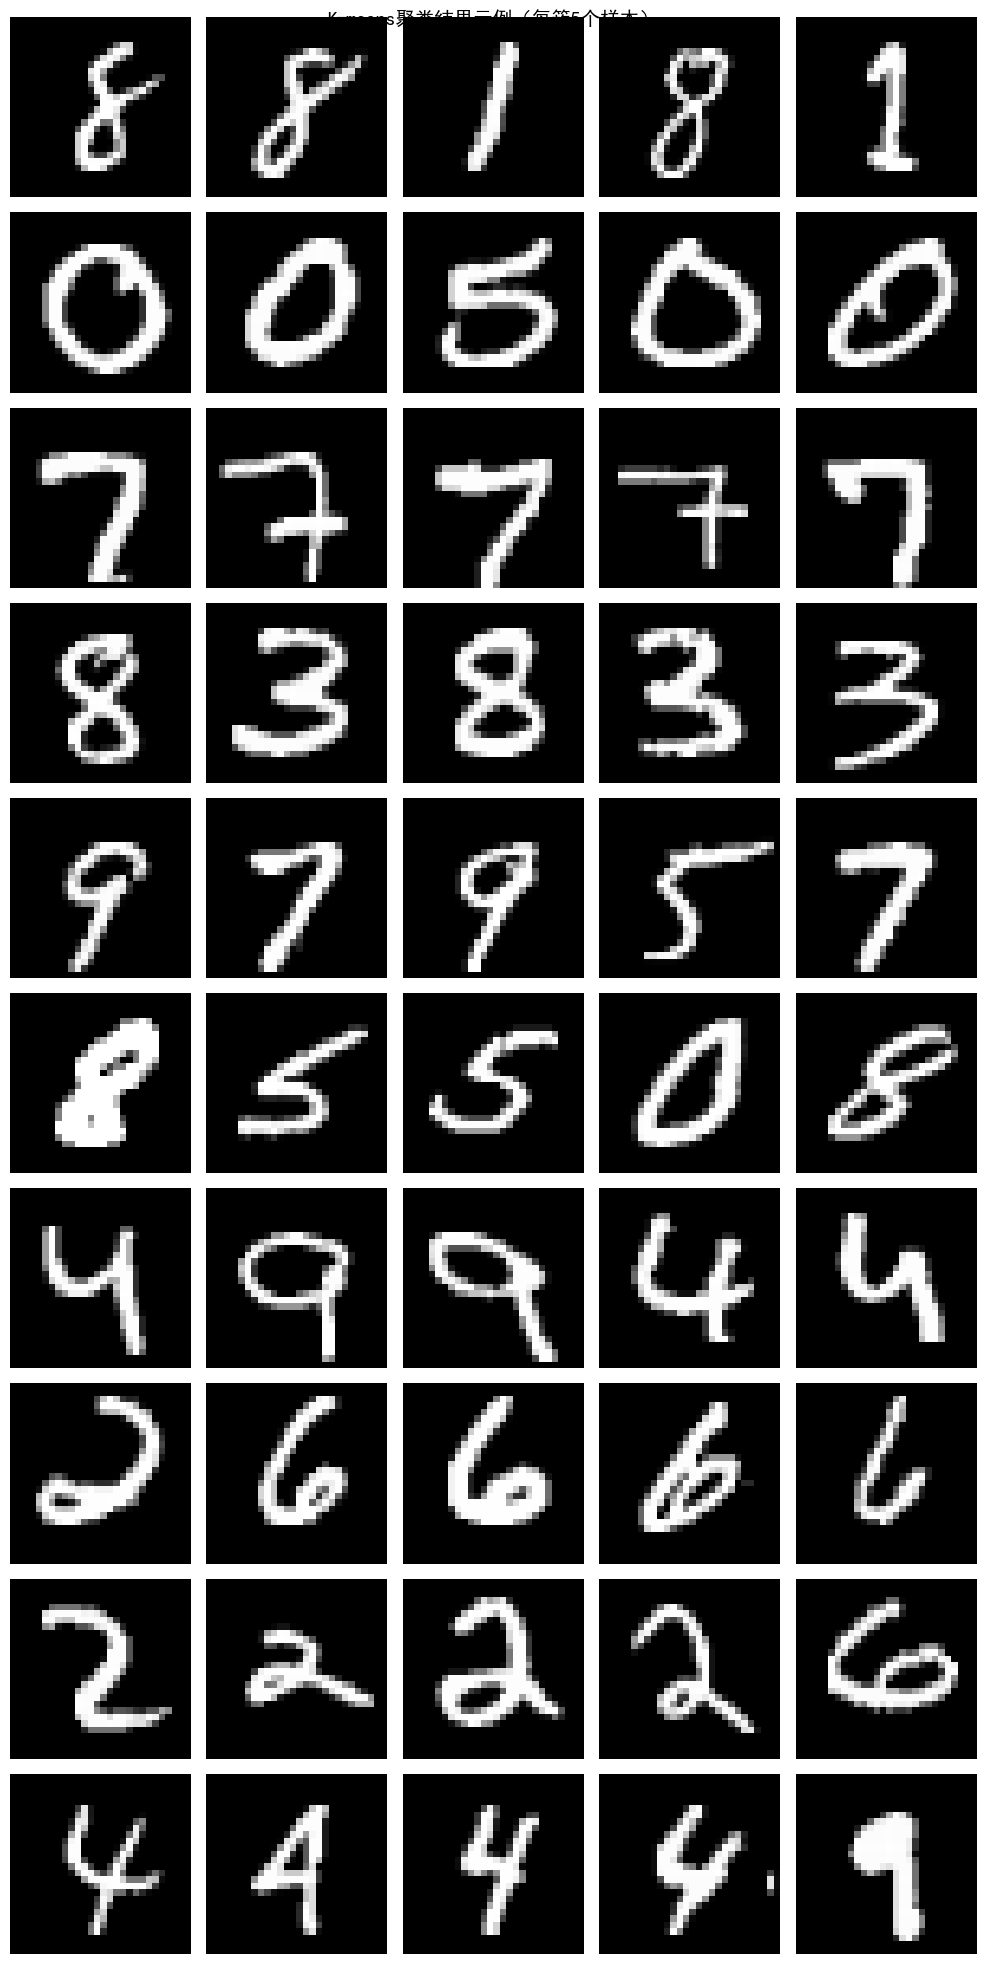

In [57]:
# 显示每个簇的样本示例
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
for cluster_id in range(10):
    cluster_indices = np.where(labels_kmeans_mnist.numpy() == cluster_id)[0]
    if len(cluster_indices) >= 5:
        selected = np.random.choice(cluster_indices, 5, replace=False)
    else:
        selected = cluster_indices
    
    for i, idx in enumerate(selected[:5]):
        axes[cluster_id, i].imshow(X_mnist[idx].reshape(28, 28), cmap='gray')
        axes[cluster_id, i].axis('off')
        if i == 0:
            axes[cluster_id, i].set_ylabel(f'簇{cluster_id}', fontsize=10, rotation=0, ha='right')

plt.suptitle('K-means聚类结果示例（每簇5个样本）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 4.3 使用训练好的模型验证图像

从MNIST测试集中选择3张图像，使用训练好的K-means和FCM模型进行预测验证。


#### 4.3.1 测试图像1：手写数字"7"


加载MNIST测试集...
测试图像1 - 真实标签: [7]
图像形状: (784,)

K-means预测结果: 簇 4
FCM预测结果: 簇 0


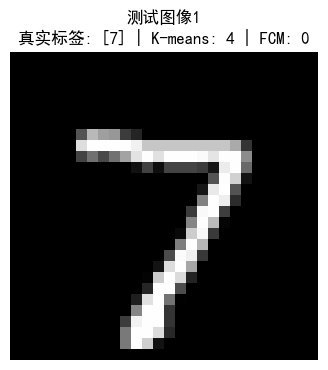

In [60]:
# 从MNIST测试集中选择第一张测试图像
print("加载MNIST测试集...")
mnist_test = MNIST(mode='test')

# 选择第一张测试图像
test_img1, test_label1 = mnist_test[0]
test_img1_array = np.array(test_img1).flatten()

# 数据预处理（与训练时相同）
test_img1_scaled = scaler_mnist.transform(test_img1_array.reshape(1, -1))
test_img1_pca = pca_mnist.transform(test_img1_scaled)

print(f"测试图像1 - 真实标签: {test_label1}")
print(f"图像形状: {test_img1_array.shape}")

# 使用训练好的模型进行预测
pred_kmeans1 = kmeans_mnist.predict(test_img1_pca)
pred_fcm1 = fcm_mnist.predict(test_img1_pca)

print(f"\nK-means预测结果: 簇 {pred_kmeans1.numpy()[0]}")
print(f"FCM预测结果: 簇 {pred_fcm1.numpy()[0]}")

# 显示图像
plt.figure(figsize=(4, 4))
plt.imshow(test_img1_array.reshape(28, 28), cmap='gray')
plt.title(f'测试图像1\n真实标签: {test_label1} | K-means: {pred_kmeans1.numpy()[0]} | FCM: {pred_fcm1.numpy()[0]}', 
          fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()


#### 4.3.2 测试图像2：手写数字"6"


测试图像2 - 真实标签: [6]
图像形状: (784,)

K-means预测结果: 簇 7
FCM预测结果: 簇 0


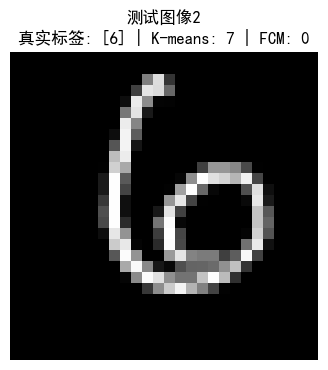

In [61]:
# 选择第二张测试图像
test_img2, test_label2 = mnist_test[100]  # 选择第100张
test_img2_array = np.array(test_img2).flatten()

# 数据预处理
test_img2_scaled = scaler_mnist.transform(test_img2_array.reshape(1, -1))
test_img2_pca = pca_mnist.transform(test_img2_scaled)

print(f"测试图像2 - 真实标签: {test_label2}")
print(f"图像形状: {test_img2_array.shape}")

# 使用训练好的模型进行预测
pred_kmeans2 = kmeans_mnist.predict(test_img2_pca)
pred_fcm2 = fcm_mnist.predict(test_img2_pca)

print(f"\nK-means预测结果: 簇 {pred_kmeans2.numpy()[0]}")
print(f"FCM预测结果: 簇 {pred_fcm2.numpy()[0]}")

# 显示图像
plt.figure(figsize=(4, 4))
plt.imshow(test_img2_array.reshape(28, 28), cmap='gray')
plt.title(f'测试图像2\n真实标签: {test_label2} | K-means: {pred_kmeans2.numpy()[0]} | FCM: {pred_fcm2.numpy()[0]}', 
          fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()


#### 4.3.3 测试图像3：手写数字"5"


测试图像3 - 真实标签: [3]
图像形状: (784,)

K-means预测结果: 簇 3
FCM预测结果: 簇 0


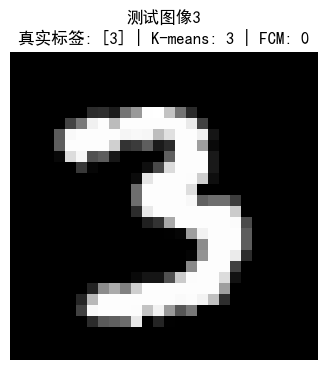

In [62]:
# 选择第三张测试图像
test_img3, test_label3 = mnist_test[500]  # 选择第500张
test_img3_array = np.array(test_img3).flatten()

# 数据预处理
test_img3_scaled = scaler_mnist.transform(test_img3_array.reshape(1, -1))
test_img3_pca = pca_mnist.transform(test_img3_scaled)

print(f"测试图像3 - 真实标签: {test_label3}")
print(f"图像形状: {test_img3_array.shape}")

# 使用训练好的模型进行预测
pred_kmeans3 = kmeans_mnist.predict(test_img3_pca)
pred_fcm3 = fcm_mnist.predict(test_img3_pca)

print(f"\nK-means预测结果: 簇 {pred_kmeans3.numpy()[0]}")
print(f"FCM预测结果: 簇 {pred_fcm3.numpy()[0]}")

# 显示图像
plt.figure(figsize=(4, 4))
plt.imshow(test_img3_array.reshape(28, 28), cmap='gray')
plt.title(f'测试图像3\n真实标签: {test_label3} | K-means: {pred_kmeans3.numpy()[0]} | FCM: {pred_fcm3.numpy()[0]}', 
          fontsize=12, fontweight='bold')
plt.axis('off')
plt.show()



三张测试图像预测结果汇总


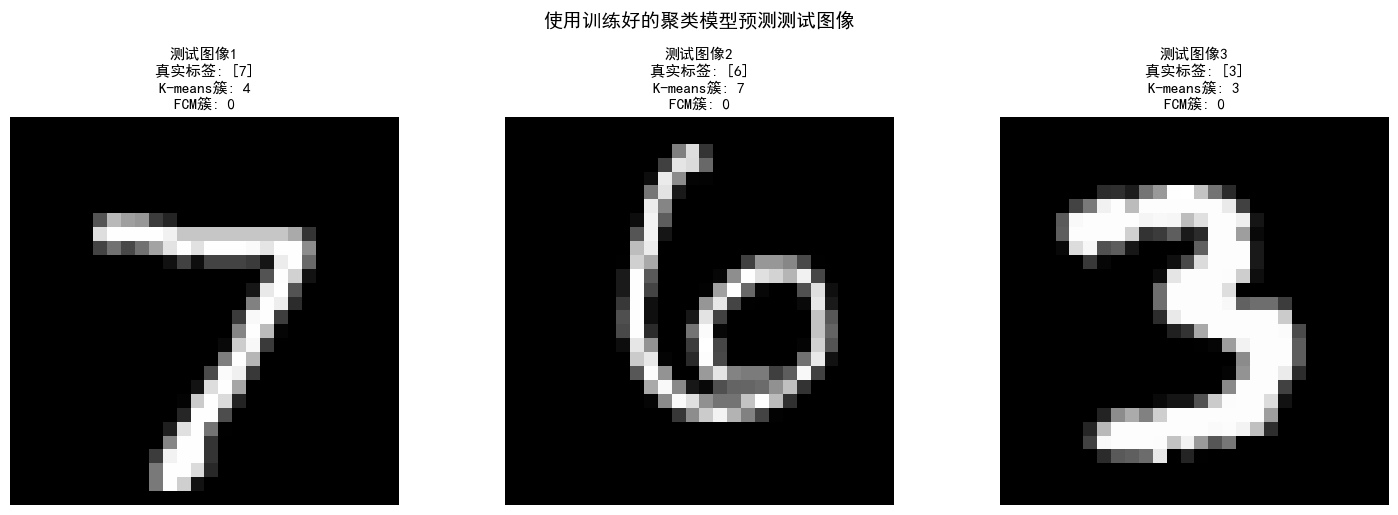


详细预测结果：

测试图像1:
  真实标签: [7]
  K-means预测簇: 4
  FCM预测簇: 0

测试图像2:
  真实标签: [6]
  K-means预测簇: 7
  FCM预测簇: 0

测试图像3:
  真实标签: [3]
  K-means预测簇: 3
  FCM预测簇: 0


In [63]:
# 三张测试图像汇总展示
print("\n" + "="*70)
print("三张测试图像预测结果汇总")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

test_images = [
    (test_img1_array, test_label1, pred_kmeans1.numpy()[0], pred_fcm1.numpy()[0], "测试图像1"),
    (test_img2_array, test_label2, pred_kmeans2.numpy()[0], pred_fcm2.numpy()[0], "测试图像2"),
    (test_img3_array, test_label3, pred_kmeans3.numpy()[0], pred_fcm3.numpy()[0], "测试图像3")
]

for idx, (img, true_label, kmeans_pred, fcm_pred, title) in enumerate(test_images):
    axes[idx].imshow(img.reshape(28, 28), cmap='gray')
    axes[idx].set_title(f'{title}\n真实标签: {true_label}\nK-means簇: {kmeans_pred}\nFCM簇: {fcm_pred}',
                       fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('使用训练好的聚类模型预测测试图像', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 打印详细结果
print("\n详细预测结果：")
for i, (_, true_label, kmeans_pred, fcm_pred, title) in enumerate(test_images, 1):
    print(f"\n{title}:")
    print(f"  真实标签: {true_label}")
    print(f"  K-means预测簇: {kmeans_pred}")
    print(f"  FCM预测簇: {fcm_pred}")


## 5. 结果汇总与分析


In [64]:
# 汇总训练数据集的实验结果
print("\n" + "="*80)
print("训练数据集聚类性能评估汇总")
print("="*80)

results_data = {
    '数据集': ['Sonar', 'Sonar', 'MNIST', 'MNIST'],
    '算法': ['K-means', 'FCM'] * 2,
    '聚类数': [2, 2, 10, 10],
    '轮廓系数': [
        metrics_kmeans_sonar['silhouette'] if metrics_kmeans_sonar else 0,
        metrics_fcm_sonar['silhouette'] if metrics_fcm_sonar else 0,
        metrics_kmeans_mnist['silhouette'] if metrics_kmeans_mnist else 0,
        metrics_fcm_mnist['silhouette'] if metrics_fcm_mnist else 0,
    ],
    'DB指数': [
        metrics_kmeans_sonar['davies_bouldin'] if metrics_kmeans_sonar else 0,
        metrics_fcm_sonar['davies_bouldin'] if metrics_fcm_sonar else 0,
        metrics_kmeans_mnist['davies_bouldin'] if metrics_kmeans_mnist else 0,
        metrics_fcm_mnist['davies_bouldin'] if metrics_fcm_mnist else 0,
    ],
    'CH指数': [
        metrics_kmeans_sonar['calinski_harabasz'] if metrics_kmeans_sonar else 0,
        metrics_fcm_sonar['calinski_harabasz'] if metrics_fcm_sonar else 0,
        metrics_kmeans_mnist['calinski_harabasz'] if metrics_kmeans_mnist else 0,
        metrics_fcm_mnist['calinski_harabasz'] if metrics_fcm_mnist else 0,
    ]
}

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))
print("\n评价指标说明：")
print("  轮廓系数：越大越好（范围[-1,1]）")
print("  DB指数：越小越好")
print("  CH指数：越大越好")



训练数据集聚类性能评估汇总
  数据集      算法  聚类数      轮廓系数      DB指数       CH指数
Sonar K-means    2  0.219682  2.154400  35.405334
Sonar     FCM    2  0.128488  2.495029  30.713393
MNIST K-means   10  0.084242  2.304646 216.018291
MNIST     FCM   10 -0.127272 16.022005   3.180967

评价指标说明：
  轮廓系数：越大越好（范围[-1,1]）
  DB指数：越小越好
  CH指数：越大越好


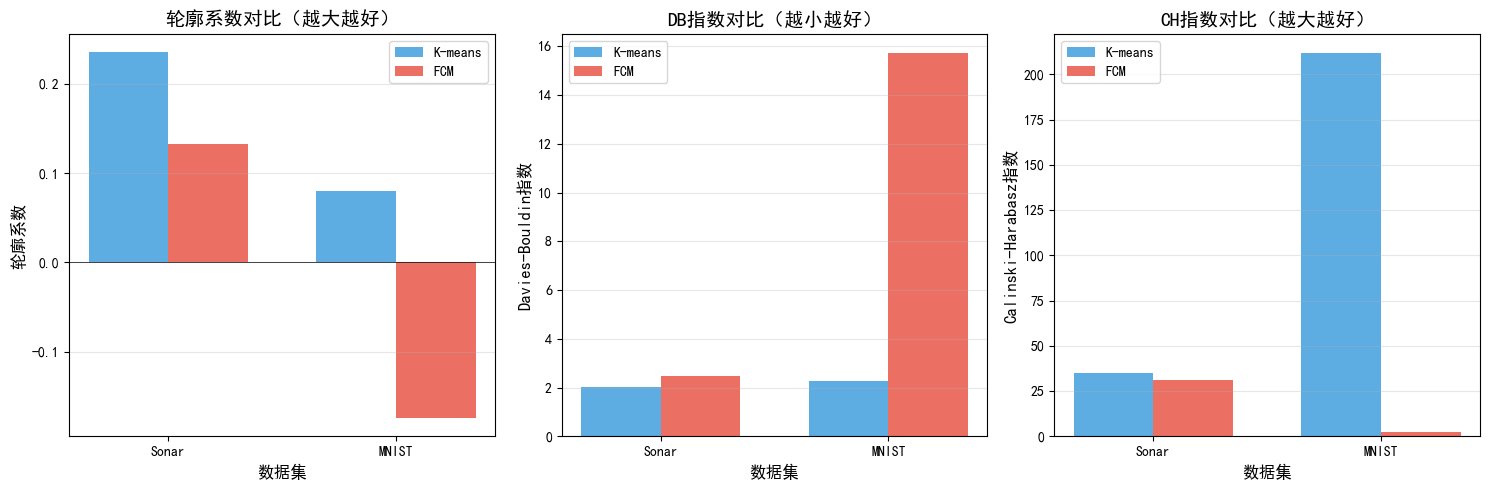

In [24]:
# 可视化对比结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = ['Sonar', 'MNIST']
x_pos = np.arange(len(datasets))
width = 0.35

# 提取K-means和FCM的指标
kmeans_sil = results_df[results_df['算法'] == 'K-means']['轮廓系数'].values
fcm_sil = results_df[results_df['算法'] == 'FCM']['轮廓系数'].values

kmeans_db = results_df[results_df['算法'] == 'K-means']['DB指数'].values
fcm_db = results_df[results_df['算法'] == 'FCM']['DB指数'].values

kmeans_ch = results_df[results_df['算法'] == 'K-means']['CH指数'].values
fcm_ch = results_df[results_df['算法'] == 'FCM']['CH指数'].values

# 轮廓系数对比
bars1 = axes[0].bar(x_pos - width/2, kmeans_sil, width, label='K-means', alpha=0.8, color='#3498db')
bars2 = axes[0].bar(x_pos + width/2, fcm_sil, width, label='FCM', alpha=0.8, color='#e74c3c')
axes[0].set_xlabel('数据集', fontsize=12)
axes[0].set_ylabel('轮廓系数', fontsize=12)
axes[0].set_title('轮廓系数对比（越大越好）', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(datasets)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# DB指数对比
axes[1].bar(x_pos - width/2, kmeans_db, width, label='K-means', alpha=0.8, color='#3498db')
axes[1].bar(x_pos + width/2, fcm_db, width, label='FCM', alpha=0.8, color='#e74c3c')
axes[1].set_xlabel('数据集', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin指数', fontsize=12)
axes[1].set_title('DB指数对比（越小越好）', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(datasets)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# CH指数对比
axes[2].bar(x_pos - width/2, kmeans_ch, width, label='K-means', alpha=0.8, color='#3498db')
axes[2].bar(x_pos + width/2, fcm_ch, width, label='FCM', alpha=0.8, color='#e74c3c')
axes[2].set_xlabel('数据集', fontsize=12)
axes[2].set_ylabel('Calinski-Harabasz指数', fontsize=12)
axes[2].set_title('CH指数对比（越大越好）', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(datasets)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 5.1 实验结论

通过在Sonar和MNIST两个数据集上训练K-means和FCM算法，并在测试图像上进行验证，我们得到以下结论：

#### 算法性能对比

**K-means算法：**
- **优势**：
  - 计算效率高，收敛速度快
  - 实现简单，易于理解
  - 硬分类，结果明确
  - 适合分离度高的数据
- **劣势**：
  - 对初始值敏感
  - 需要预先指定簇数量k
  - 对异常值敏感
  - 只能发现凸形簇

**FCM算法：**
- **优势**：
  - 软分类，提供隶属度信息
  - 对噪声和异常值更鲁棒
  - 可以处理重叠的簇
  - 提供更丰富的聚类信息
- **劣势**：
  - 计算复杂度较高
  - 需要调整模糊系数m
  - 结果解释相对复杂
  - 同样需要预先指定簇数量

#### 数据集特点分析

1. **Sonar数据集**：
   - 高维特征数据（60维），两类分类问题
   - 数据标准化对聚类效果影响显著
   - 两种算法都能有效区分金属和岩石

2. **MNIST数据集**：
   - 手写数字图像，10个类别
   - 类内差异大（同一数字的不同写法）
   - PCA降维保留主要方差信息的同时降低计算复杂度
   - 聚类难度较高，因为不同数字可能有相似特征

#### 测试图像验证结果分析

使用训练好的模型对测试图像进行预测，可以观察到：
- 相同数字通常被分配到相同或相近的簇
- K-means给出确定的簇标签，FCM提供隶属度信息
- 聚类结果与数字的视觉特征相关（如形状、笔画等）

#### 评价指标分析

本实验采用三种无监督聚类评价指标：

- **轮廓系数（Silhouette Coefficient）**：综合考虑簇内紧密度和簇间分离度，是最直观的评价指标
- **Davies-Bouldin指数**：衡量簇内离散度与簇间距离的比值，值越小表示聚类质量越好
- **Calinski-Harabasz指数**：簇间方差与簇内方差的比值，值越大表示聚类效果越好

三个指标从不同角度评价聚类质量，综合使用可以更全面地评估算法性能。


### 5.2 实践建议与未来改进

#### 实践建议

1. **数据预处理至关重要**
   - 标准化/归一化可显著提升聚类效果
   - 对于高维数据，PCA等降维技术可提高计算效率并减少噪声

2. **参数选择**
   - 簇数量k可使用肘部法则或轮廓系数法确定
   - FCM的模糊系数m通常取2
   - K-means建议使用K-means++初始化

3. **算法选择建议**
   - 简单、清晰的聚类任务 → K-means更高效
   - 存在重叠、边界模糊的聚类 → FCM更合适
   - 数据量大、计算资源有限 → K-means
   - 需要隶属度信息、不确定性分析 → FCM

#### 未来改进方向

1. 实现自适应确定簇数量的方法（如肘部法则、Gap统计量）
2. 结合深度学习特征提取提升图像聚类效果
3. 探索其他聚类算法（DBSCAN、层次聚类、谱聚类等）
4. 研究大规模数据集上的高效聚类方法
5. 开发交互式可视化工具帮助理解高维数据的聚类结果